### Agent-Lab: Vision Document Agent

Objective of this notebook is evaluating and adapting the implementation of [Multi-modal Agent](https://python.langchain.com/docs/integrations/llms/ollama/#multi-modal) specialized on documents.

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    OLLAMA_ENDPOINT="http://localhost:11434"
    OLLAMA_MODEL_TAG="llama3.2-vision:latest"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent_id = experiment_utils.create_ollama_agent(
    agent_type="vision_document",
    llm_tag="minicpm-v:latest",
    ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
)

# create first attachment
first_attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/vision_document_01.png",
    content_type="image/png"
)

# create second attachment
second_attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/vision_document_02.png",
    content_type="image/png"
)

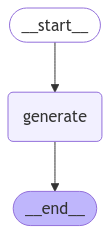

In [3]:
# get agent instance
vision_document_agent = container.vision_document_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = vision_document_agent.get_workflow_builder(agent_id)
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [4]:
agent_config = {
    "configurable": {
        "thread_id": agent_id,
    },
    "recursion_limit": 30
}

In [5]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Describe the code present on the image.",
    agent_id=agent_id,
    attachment_id=first_attachment_id
)

inputs = vision_document_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [6]:
print(result['generation'])

{
  "short_description": "A screenshot showing a GitHub repository page for agent-lab/notebooks/vision_document_agent.ipynb",
  "detailed_analysis": "<p>The image shows an open web browser displaying a GitHub repository. The title of the repository is 'agent-lab/notebooks/vision_document_agent.ipynb'. It appears to be related to vision document agents and Multi-modal Agent implementation on documents.</p><ul><li>GitHub interface elements such as code, blame tab, preview button, comments, bookmarks are visible</li><li>The language of the content is English (ISO 639-3: en)</li></ul>",
  "lessons_learned": "<ol type='1'><li>Understanding GitHub repository structure and navigation.</li><li>Recognizing code snippets in Jupyter Notebook format (.ipynb extension).</li><li>Learning how to read and interpret information on a GitHub project page.</li></ol>",
  "detected_languages": ["en"],
  "business_value": "<ul type='1'><li>Understand the structure of open-source projects hosted on GitHub, su

In [7]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Is the code present on this image related to previous image? Can you reason about the entire code and describe what it does?",
    agent_id=agent_id,
    attachment_id=second_attachment_id
)

inputs = vision_document_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [8]:
print(result['generation'])

{
  "short_description": "GitHub repository showing Python notebook for vision document agent",
  "detailed_analysis": "The image displays an open GitHub interface with the 'agent-lab/notebooks/vision_document_agent.ipynb' project. The code snippets in Jupyter Notebook format (.ipynb extension) are visible, including functions and variables related to creating agents and managing checkpoints for vision document processing.",
  "lessons Learned": "The image shows how Python notebook files can be used on GitHub repositories for collaborative development of software projects. Understanding the structure and navigation within a specific project page is essential when working with open-source code hosted on platforms like GitHub.",
  "detected_languages": "English (ISO 639-3: en)",
  "business_value": "The repository appears to be related to vision document processing, indicating potential applications in natural language understanding or computer vision tasks. The use of Jupyter Notebook f